### **Model Creation, Interpretation & Solution**


### **Contents**

4. Summary of Feature Engineering
5. Summary of Model Experiment
6. Modeling
5. Conclusion & Analysis
6. Recommendation

****

In [99]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
#load the data
df = pd.read_csv('data_saudi_used_cars.csv')
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


In [101]:
#Clean the data. The explanation on why to clean the data have been explained in business_eda.ipynb
df.drop_duplicates(keep='last', inplace=True, ignore_index=True)
df = df[df['Price'] != 0]
df = df[df['Price'] < 8000] #the least amount of car price compared to least amount of new motorcycle price in saudi arabia

In [102]:
def winsorize_lower(x, lower_percentile=0.05):
    lower_limit = x.quantile(lower_percentile)
    x_cleaned = x.clip(lower=lower_limit)
    num_winsorized = (x < lower_limit).sum()
    return x_cleaned, num_winsorized

# Assuming df is your DataFrame and 'Price' is the column you want to winsorize
df['Price'], num_winsorized = winsorize_lower(df['Price'])

print(f"Number of values winsorized: {num_winsorized}")


Number of values winsorized: 5


We drop and winsorized the lower value of the Prize because there are many lower percentile of price that doesn't make any sense ex/: price 1, 5, 100, 250. We assume that this price happen due to the condition of the vehicle that can not be shown in this data, such as: crash car, accident car, missing parts or body, broken car, flooden car, etc.

***

### **Summary of Feature Engineering**



1. Feature Selection

- minimizing ML bias

For this case, we will not be using Region Feature. We want to minimize the bias of where the car is sold. If we look at the Region column closely, for example, The Riyadh Car is more expensive rather than the car sold in any parts of Saudi Arabia. We do not want this to happen since we want to estabilish a single price for every car sold in every Saudi. 

- using selection

This case have many high cardinality column. This rise a few problem in relation of capability of model, such as model overfitting. Because of that, we will use some selection methode to choose which encoded feature that wuill be used. This will be used in **experiment 2** & **experiment 4** 

2. Feature Engineering

We will combine several columns to make model learn and understand the relation and the intersection of the feature that we feel would be helpful for better model prediction. This will be used in **experiment 3** & **experiment 4** . For example:

- df[Wear and Tear] = df.mileage * df.age This feature emphasize of how much the car is wear and tear in relation to the price of those car

***

### **Summary of Model Experiment Summary**

    - Experiment Explained. Why we do thies experiment?
In the following section, we summarize the series of experiments conducted to improve the regression model for predicting car prices. Each experiment was designed with a specific goal to incrementally enhance model performance and derive insights for further refinement.

- Experiment 1

    Objective: To establish a baseline performance for the model using all available features.
    Description: In this initial experiment, the model was trained using all the features without any modifications or interventions. This approach aims to understand how the model performs with the full dataset and provides a reference point for subsequent experiments.
    Outcome: The results from this experiment will serve as a benchmark, offering valuable insights into the initial performance of the model with a comprehensive feature set.

- Experiment 2

    Objective: To evaluate the impact of feature selection on model performance.
    Description: In the second experiment, we applied feature selection methods to identify and use only a subset of encoded features. This experiment aims to understand how the model performs when only the most relevant features are included, without extensive feature creation based on domain knowledge.
    Outcome: This experiment helps determine the effectiveness of feature selection techniques and their impact on model accuracy compared to using all features.

- Experiment 3

    Objective: To improve model performance through feature creation using domain knowledge.
    Description: The third experiment focused on creating new features informed by domain expertise. These features were designed to capture additional nuances and factors that might influence car prices, which were not initially included in the dataset.
    Outcome: The results from this experiment will indicate the value added by domain-specific feature engineering and its effect on enhancing model predictions.

- Experiment 4

    Objective: To combine feature creation and feature selection for optimal model performance.
    Description: The fourth experiment integrated the domain-specific features created in Experiment 3 with the feature selection methods from Experiment 2. The goal was to identify the most effective subset of features that balance relevance and comprehensiveness, thus improving model efficiency and accuracy.
    Outcome: This experiment aims to achieve a more effective model by leveraging the strengths of both feature creation and selection, ensuring that only the most impactful features are used for prediction.



# **Experiment 1**

The first experiment will be using all the feature. The first experiment is intended to see how the model works without much intervention. Hence, in this experiment, we make as little changes as possible. The result of this experiment will be used as the information for the foloowing experiment. 

In [103]:
from sklearn.model_selection import train_test_split
# Split the dataset
RANDOM_STATE = 42
df_seen, df_unseen = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define a function to perform log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define the log transformation transformer
log_transformer = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(LogTransformer().transform, validate=False))
    ]
)

# Custom transformer to transform Year to Age
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = 2023 - X['Year']
        X.drop(columns=['Year'], inplace=True)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['Age'] + [f for f in input_features if f != 'Year']

# Winsorization transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=0.05):
        self.limits = limits
    
    def fit(self, X, y=None):
        self.lower_limit = X.quantile(self.limits)
        self.upper_limit = X.quantile(1 - self.limits)
        return self
    
    def transform(self, X):
        return X.clip(self.lower_limit, self.upper_limit, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define individual pipelines for different feature types
cat1_features_type = ['Type']
cat1_transformer_type = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(mutual_info_regression, k='all')) 
    ]
)

cat1_features_make = ['Make']
cat1_transformer_make = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(mutual_info_regression, k='all'))  
    ]
)

cat2_features = ['Gear_Type', 'Options']
cat2_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop='first'))
    ]
)

num1_features = ['Year']
num1_transformer = Pipeline(
    steps=[
        ("custom", CustomPreprocessor()),
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

num2_features = ['Mileage', 'Engine_Size']
num2_transformer = Pipeline(
    steps=[
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat1_type", cat1_transformer_type, cat1_features_type),
        ("cat1_make", cat1_transformer_make, cat1_features_make),
        ("cat2", cat2_transformer, cat2_features),
        ("num1", num1_transformer, num1_features),
        ("num2", num2_transformer, num2_features)
    ]
)

from pycaret.regression import RegressionExperiment

# Define the setup configuration dictionary
setup = {
    'data': df_seen, 
    'target': 'Price',
    'train_size': 0.8,
    'verbose': False,
    'session_id': RANDOM_STATE,
    'ignore_features': ['Region', 'Origin', 'Negotiable'],
    'preprocess': False,  # Disable automatic preprocessing
    'imputation_type': None,
    'custom_pipeline_position': 0  # Position of the custom pipeline in preprocessing
}

# Initialize the RegressionExperiment
exp1 = RegressionExperiment()

# Set up the experiment with the custom pipeline and setup configuration
exp1.setup(custom_pipeline=preprocessor, **setup)

# Retrieve the configured pipeline
pipeline = exp1.get_config('pipeline')


In [105]:
pipeline

Pipeline(memory=FastMemory(location=C:\Users\ASUS\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(transformer=ColumnTransformer(transformers=[('cat1_type',
                                                                                 Pipeline(steps=[('binary',
                                                                                                  BinaryEncoder()),
                                                                                                 ('select',
                                                                                                  SelectKBest(k='all',
                                                                                                              score_func=<function mutual_info_regression at 0x00000248B3379C60>))]),
                                                                                 ['Type']),
                                                                                ('cat1_make',
                                                                                 Pipeline(st...
                                                                                 ['Make']),
                                                                                ('cat2',
                                                                                 Pipeline(steps=[('onehot',
                                                                                                  OneHotEncoder(drop='first'))]),
                                                                                 ['Gear_Type',
                                                                                  'Options']),
                                                                                ('num1',
                                                                                 Pipeline(steps=[('custom',
                                                                                                  CustomPreprocessor()),
                                                                                                 ('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Year']),
                                                                                ('num2',
                                                                                 Pipeline(steps=[('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Mileage',
                                                                                  'Engine_Size'])])))])

In [106]:
exp1.get_config('X_transformed')

,cat1_type__Type_0,cat1_type__Type_1,cat1_type__Type_2,cat1_type__Type_3,cat1_type__Type_4,cat1_type__Type_5,cat1_make__Make_0,cat1_make__Make_1,cat1_make__Make_2,cat1_make__Make_3,cat1_make__Make_4,cat2__Gear_Type_Manual,cat2__Options_Semi Full,cat2__Options_Standard,num1__Age,num2__Mileage,num2__Engine_Size
3471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.609438,11.350418,0.955511
905,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.945910,10.915198,0.955511
422,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.386294,10.757924,1.098612
3988,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.791759,12.043560,1.568616
3490,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.791759,11.326608,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.386294,10.364104,0.955511
3613,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.609438,11.396403,1.098612
3109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.079442,11.853973,1.840550
1664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.098612,9.210440,1.252763


In [107]:
exp1.create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1368.1659,2212927.2491,1487.5911,-88.0498,0.7890,1.1814
1,1493.7761,3702049.5954,1924.0711,0.0869,0.4509,0.4129
2,1821.4463,4046790.6812,2011.6637,0.1153,2.1935,0.5751
3,1590.6266,3191144.7120,1786.3775,-0.4973,0.7178,0.7288
4,1025.5830,2351230.4416,1533.3722,0.6229,0.7141,0.3894
5,631.6031,650572.5218,806.5808,-0.7766,0.4296,0.4602
6,959.7957,1742347.7927,1319.9802,0.5485,0.4872,0.4294
7,826.3767,944884.6303,972.0518,0.8079,0.4918,0.4152
8,1335.3243,2937425.7339,1713.8920,-0.1236,0.5521,0.6127


LinearRegression(n_jobs=-1)

In [108]:
exp1.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,729.0134,1123437.0419,940.2376,-0.6038,0.3155,0.2933,0.2110
gbr,Gradient Boosting Regressor,806.5424,1486174.8350,1088.5808,-0.8542,0.3615,0.3147,0.1620
et,Extra Trees Regressor,944.0931,1773254.3466,1219.5490,-0.9392,0.3948,0.3646,0.2310
ada,AdaBoost Regressor,802.5654,1335789.8924,1038.6934,-1.1368,0.3366,0.3315,0.1460
xgboost,Extreme Gradient Boosting,858.0129,1571233.9906,1159.5613,-1.1475,0.4054,0.3299,0.3000
catboost,CatBoost Regressor,776.5202,1289050.5910,1064.0387,-1.3171,0.3399,0.3100,2.8600
dt,Decision Tree Regressor,862.4853,1567104.0633,1137.3414,-2.7076,0.4216,0.3630,0.0810
par,Passive Aggressive Regressor,1179.4169,3388085.8552,1681.3930,-3.8655,0.5441,0.4176,0.1110
omp,Orthogonal Matching Pursuit,922.8865,1430955.3788,1143.1520,-5.6047,0.5190,0.4803,0.0830
knn,K Neighbors Regressor,1078.1106,2864303.0375,1548.4463,-5.6275,0.5070,0.4087,0.1600


RandomForestRegressor(n_jobs=-1, random_state=42)

Conclusion of Experiment 1

A negative R2 score in conjunction with good MAE, MSE, RMSE, and other metrics suggests that while your model may produce reasonably accurate predictions on average, it fails to capture the variability in the target variable better than a simple mean prediction. Improving the model's ability to generalize and capturing the variability in the data should be the focus.

# **Experiment 2**

The second experiment will not be using all the feature. The second experiment is intended to see how the model works when we select a few of encoded features using selection method of mutual information regression without much intervention on feature creation using domain knowledge. We also change our apprach from robustscaler into log transformer 

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define a function to perform log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define the log transformation transformer
log_transformer = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(LogTransformer().transform, validate=False))
    ]
)

# Custom transformer to transform Year to Age
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = 2023 - X['Year']
        X.drop(columns=['Year'], inplace=True)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['Age'] + [f for f in input_features if f != 'Year']

# Winsorization transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=0.05):
        self.limits = limits
    
    def fit(self, X, y=None):
        self.lower_limit = X.quantile(self.limits)
        self.upper_limit = X.quantile(1 - self.limits)
        return self
    
    def transform(self, X):
        return X.clip(self.lower_limit, self.upper_limit, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define individual pipelines for different feature types
cat1_features_type = ['Type']
cat1_transformer_type = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(mutual_info_regression, k=30))  # Select 30 features for Type
    ]
)

cat1_features_make = ['Make']
cat1_transformer_make = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(mutual_info_regression, k=7))  # Select 7 features for Make
    ]
)

cat2_features = ['Gear_Type', 'Options']
cat2_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop='first'))
    ]
)

num1_features = ['Year']
num1_transformer = Pipeline(
    steps=[
        ("custom", CustomPreprocessor()),
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

num2_features = ['Mileage', 'Engine_Size']
num2_transformer = Pipeline(
    steps=[
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat1_type", cat1_transformer_type, cat1_features_type),
        ("cat1_make", cat1_transformer_make, cat1_features_make),
        ("cat2", cat2_transformer, cat2_features),
        ("num1", num1_transformer, num1_features),
        ("num2", num2_transformer, num2_features)
    ]
)

from pycaret.regression import RegressionExperiment

# Define the setup configuration dictionary
setup = {
    'data': df_seen, 
    'target': 'Price',
    'train_size': 0.8,
    'verbose': False,
    'session_id': RANDOM_STATE,
    'ignore_features': ['Region', 'Origin', 'Negotiable'],
    'preprocess': False,  # Disable automatic preprocessing
    'imputation_type': None,
    'custom_pipeline_position': 0  # Position of the custom pipeline in preprocessing
}

# Initialize the RegressionExperiment
exp2 = RegressionExperiment()

# Set up the experiment with the custom pipeline and setup configuration
exp2.setup(custom_pipeline=preprocessor, **setup)

# Retrieve the configured pipeline
pipeline2 = exp2.get_config('pipeline')


In [110]:
pipeline2

Pipeline(memory=FastMemory(location=C:\Users\ASUS\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(transformer=ColumnTransformer(transformers=[('cat1_type',
                                                                                 Pipeline(steps=[('binary',
                                                                                                  BinaryEncoder()),
                                                                                                 ('select',
                                                                                                  SelectKBest(k=30,
                                                                                                              score_func=<function mutual_info_regression at 0x00000248B3379C60>))]),
                                                                                 ['Type']),
                                                                                ('cat1_make',
                                                                                 Pipeline(steps...
                                                                                 ['Make']),
                                                                                ('cat2',
                                                                                 Pipeline(steps=[('onehot',
                                                                                                  OneHotEncoder(drop='first'))]),
                                                                                 ['Gear_Type',
                                                                                  'Options']),
                                                                                ('num1',
                                                                                 Pipeline(steps=[('custom',
                                                                                                  CustomPreprocessor()),
                                                                                                 ('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Year']),
                                                                                ('num2',
                                                                                 Pipeline(steps=[('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Mileage',
                                                                                  'Engine_Size'])])))])

In [111]:
exp2.get_config('X_transformed')

,cat1_type__Type_0,cat1_type__Type_1,cat1_type__Type_2,cat1_type__Type_3,cat1_type__Type_4,cat1_type__Type_5,cat1_make__Make_0,cat1_make__Make_1,cat1_make__Make_2,cat1_make__Make_3,cat1_make__Make_4,cat2__Gear_Type_Manual,cat2__Options_Semi Full,cat2__Options_Standard,num1__Age,num2__Mileage,num2__Engine_Size
3471,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.609438,11.350418,0.955511
905,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.945910,10.915198,0.955511
422,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.386294,10.757924,1.098612
3988,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.791759,12.043560,1.568616
3490,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.791759,11.326608,1.098612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.386294,10.364104,0.955511
3613,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.609438,11.396403,1.098612
3109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.079442,11.853973,1.840550
1664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.098612,9.210440,1.252763


In [112]:
exp2.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,729.0134,1123437.0419,940.2376,-0.6038,0.3155,0.2933,0.2020
gbr,Gradient Boosting Regressor,806.5424,1486174.8350,1088.5808,-0.8542,0.3615,0.3147,0.1230
et,Extra Trees Regressor,944.0931,1773254.3466,1219.5490,-0.9392,0.3948,0.3646,0.1700
ada,AdaBoost Regressor,802.5654,1335789.8924,1038.6934,-1.1368,0.3366,0.3315,0.2000
xgboost,Extreme Gradient Boosting,858.0129,1571233.9906,1159.5613,-1.1475,0.4054,0.3299,0.1100
catboost,CatBoost Regressor,776.5202,1289050.5910,1064.0387,-1.3171,0.3399,0.3100,1.1220
dt,Decision Tree Regressor,862.4853,1567104.0633,1137.3414,-2.7076,0.4216,0.3630,0.0800
par,Passive Aggressive Regressor,1179.4169,3388085.8552,1681.3930,-3.8655,0.5441,0.4176,0.0810
omp,Orthogonal Matching Pursuit,922.8865,1430955.3788,1143.1520,-5.6047,0.5190,0.4803,0.0810
knn,K Neighbors Regressor,1078.1106,2864303.0375,1548.4463,-5.6275,0.5070,0.4087,0.1470


RandomForestRegressor(n_jobs=-1, random_state=42)

conclution of experiment 2

if we look at the result, the R2 is still negative and there are little to no result in changing our approach from experiment 1 and experiment 2

# **Experiment 3**

The third experiment will focus on removing feature to make a room for variance. This is due to the negative r2

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define a function to perform log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define the log transformation transformer
log_transformer = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(LogTransformer().transform, validate=False))
    ]
)

# Custom transformer to transform Year to Age
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = 2023 - X['Year']
        X.drop(columns=['Year'], inplace=True)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['Age'] + [f for f in input_features if f != 'Year']

# Winsorization transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=0.05):
        self.limits = limits
    
    def fit(self, X, y=None):
        self.lower_limit = X.quantile(self.limits)
        self.upper_limit = X.quantile(1 - self.limits)
        return self
    
    def transform(self, X):
        return X.clip(self.lower_limit, self.upper_limit, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define individual pipelines for different feature types
cat1_features_type = ['Make']
cat1_transformer_type = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(mutual_info_regression, k=7))  # Select 30 features for Type
    ]
)

cat2_features = ['Gear_Type', 'Options']
cat2_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop='first'))
    ]
)

num1_features = ['Year']
num1_transformer = Pipeline(
    steps=[
        ("custom", CustomPreprocessor()),
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

num2_features = ['Mileage', 'Engine_Size']
num2_transformer = Pipeline(
    steps=[
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat1_type", cat1_transformer_type, cat1_features_type),
        ("cat2", cat2_transformer, cat2_features),
        ("num1", num1_transformer, num1_features),
        ("num2", num2_transformer, num2_features)
    ]
)



In [152]:
from pycaret.regression import RegressionExperiment

# Define the setup configuration dictionary
setup = {
    'data': df_seen, 
    'target': 'Price',
    'train_size': 0.8,
    'verbose': False,
    'session_id': RANDOM_STATE,
    'ignore_features': ['Region', 'Origin', 'Negotiable','Type'],
    'preprocess': False,  # Disable automatic preprocessing
    'imputation_type': None,
    'custom_pipeline_position': 0  # Position of the custom pipeline in preprocessing
}


In [153]:
# Initialize the RegressionExperiment
exp3 = RegressionExperiment()

# Set up the experiment with the custom pipeline and setup configuration
exp3.setup(custom_pipeline=preprocessor, **setup)

# Retrieve the configured pipeline
pipeline3 = exp3.get_config('pipeline')

In [154]:
pipeline3

Pipeline(memory=FastMemory(location=C:\Users\ASUS\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(transformer=ColumnTransformer(transformers=[('cat1_type',
                                                                                 Pipeline(steps=[('binary',
                                                                                                  BinaryEncoder()),
                                                                                                 ('select',
                                                                                                  SelectKBest(k=7,
                                                                                                              score_func=<function mutual_info_regression at 0x00000248B3379C60>))]),
                                                                                 ['Make']),
                                                                                ('cat2',
                                                                                 Pipeline(steps=[('onehot',
                                                                                                  OneHotEncoder(drop='first'))]),
                                                                                 ['Gear_Type',
                                                                                  'Options']),
                                                                                ('num1',
                                                                                 Pipeline(steps=[('custom',
                                                                                                  CustomPreprocessor()),
                                                                                                 ('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Year']),
                                                                                ('num2',
                                                                                 Pipeline(steps=[('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Mileage',
                                                                                  'Engine_Size'])])))])

In [155]:
exp3.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,716.0111,1084903.9764,940.3742,-0.5780,0.3153,0.2907,0.2220
catboost,CatBoost Regressor,824.1308,1469160.0079,1134.7909,-0.7834,0.3540,0.3294,1.7320
et,Extra Trees Regressor,902.3005,1680835.5203,1170.2098,-0.9102,0.3688,0.3632,0.1800
gbr,Gradient Boosting Regressor,799.3472,1375427.2861,1049.9179,-1.0567,0.3524,0.3312,0.1100
ada,AdaBoost Regressor,781.7637,1255430.8127,1002.3465,-1.2478,0.3387,0.3351,0.1280
xgboost,Extreme Gradient Boosting,914.3927,1891106.7812,1244.7431,-1.4036,0.3989,0.3532,0.1850
dt,Decision Tree Regressor,832.7540,1415561.0439,1057.6083,-2.8054,0.3696,0.3458,0.0630
lr,Linear Regression,1023.4280,1783260.0037,1260.1375,-3.8914,0.6917,0.4921,1.5350
lar,Least Angle Regression,1023.4280,1783260.0037,1260.1375,-3.8914,0.6917,0.4921,0.0680
llar,Lasso Least Angle Regression,1020.6943,1769617.9468,1256.5635,-3.9442,0.6769,0.4915,0.0630


RandomForestRegressor(n_jobs=-1, random_state=42)

# **Experiment 4**

The fourth experiment will be done by changing our method in selecting features. This experiment intended to see how the model works when we only choose several featuer. Also, this experiment used to make the model more effective. 

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# Define a function to perform log transformation
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define the log transformation transformer
log_transformer = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(LogTransformer().transform, validate=False))
    ]
)

# Custom transformer to transform Year to Age
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Age'] = 2023 - X['Year']
        X.drop(columns=['Year'], inplace=True)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['Age'] + [f for f in input_features if f != 'Year']

# Winsorization transformer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=0.05):
        self.limits = limits
    
    def fit(self, X, y=None):
        self.lower_limit = X.quantile(self.limits)
        self.upper_limit = X.quantile(1 - self.limits)
        return self
    
    def transform(self, X):
        return X.clip(self.lower_limit, self.upper_limit, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

# Define individual pipelines for different feature types
cat1_features_type = ['Make']
cat1_transformer_type = Pipeline(
    steps=[
        ("binary", BinaryEncoder()),
        ("select", SelectKBest(score_func=f_regression, k=7))  # Select 30 features for Type
    ]
)

cat2_features = ['Gear_Type', 'Options']
cat2_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop='first'))
    ]
)

num1_features = ['Year']
num1_transformer = Pipeline(
    steps=[
        ("custom", CustomPreprocessor()),
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

num2_features = ['Mileage', 'Engine_Size']
num2_transformer = Pipeline(
    steps=[
        ("winsorize", Winsorizer()),
        ("log_transform", LogTransformer())  # Include log transformation directly
    ]
)

# Combine all pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat1_type", cat1_transformer_type, cat1_features_type),
        ("cat2", cat2_transformer, cat2_features),
        ("num1", num1_transformer, num1_features),
        ("num2", num2_transformer, num2_features)
    ]
)

from pycaret.regression import RegressionExperiment

# Define the setup configuration dictionary
setup = {
    'data': df_seen, 
    'target': 'Price',
    'train_size': 0.8,
    'verbose': False,
    'session_id': RANDOM_STATE,
    'ignore_features': ['Region', 'Origin', 'Negotiable','Type'],
    'preprocess': False,  # Disable automatic preprocessing
    'imputation_type': None,
    'custom_pipeline_position': 0  # Position of the custom pipeline in preprocessing
}

# Initialize the RegressionExperiment
exp4 = RegressionExperiment()

# Set up the experiment with the custom pipeline and setup configuration
exp4.setup(custom_pipeline=preprocessor, **setup)

# Retrieve the configured pipeline
pipeline4 = exp4.get_config('pipeline')


In [131]:
pipeline4

Pipeline(memory=FastMemory(location=C:\Users\ASUS\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(transformer=ColumnTransformer(transformers=[('cat1_type',
                                                                                 Pipeline(steps=[('binary',
                                                                                                  BinaryEncoder()),
                                                                                                 ('select',
                                                                                                  SelectKBest(k=7,
                                                                                                              score_func=<function f_regression at 0x00000248B337BD80>))]),
                                                                                 ['Make']),
                                                                                ('cat2',
                                                                                 Pipeline(steps=[('onehot',
                                                                                                  OneHotEncoder(drop='first'))]),
                                                                                 ['Gear_Type',
                                                                                  'Options']),
                                                                                ('num1',
                                                                                 Pipeline(steps=[('custom',
                                                                                                  CustomPreprocessor()),
                                                                                                 ('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Year']),
                                                                                ('num2',
                                                                                 Pipeline(steps=[('winsorize',
                                                                                                  Winsorizer()),
                                                                                                 ('log_transform',
                                                                                                  LogTransformer())]),
                                                                                 ['Mileage',
                                                                                  'Engine_Size'])])))])

In [132]:
exp4.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,716.0111,1084903.9764,940.3742,-0.5780,0.3153,0.2907,0.2060
catboost,CatBoost Regressor,824.1308,1469160.0079,1134.7909,-0.7834,0.3540,0.3294,1.0970
et,Extra Trees Regressor,902.3005,1680835.5203,1170.2098,-0.9102,0.3688,0.3632,0.1550
gbr,Gradient Boosting Regressor,799.3472,1375427.2861,1049.9179,-1.0567,0.3524,0.3312,0.1000
ada,AdaBoost Regressor,781.7637,1255430.8127,1002.3465,-1.2478,0.3387,0.3351,0.1100
xgboost,Extreme Gradient Boosting,914.3927,1891106.7812,1244.7431,-1.4036,0.3989,0.3532,0.0890
dt,Decision Tree Regressor,832.7540,1415561.0439,1057.6083,-2.8054,0.3696,0.3458,0.0580
lr,Linear Regression,1023.4280,1783260.0037,1260.1375,-3.8914,0.6917,0.4921,0.0490
lar,Least Angle Regression,1023.4280,1783260.0037,1260.1375,-3.8914,0.6917,0.4921,0.0530
llar,Lasso Least Angle Regression,1020.6943,1769617.9468,1256.5635,-3.9442,0.6769,0.4915,0.0490


RandomForestRegressor(n_jobs=-1, random_state=42)

Through these experiments, we systematically explored various approaches to feature utilization, from using all available features to selective inclusion and domain-specific creation. By comparing the results of each experiment, we can identify the most effective strategies for improving our regression model's performance in predicting car prices. This iterative approach ensures a robust and well-informed development process, ultimately leading to more accurate and reliable predictions.

***

### **Analytics**

In [156]:
best = exp3.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,449.5060,267036.8905,516.7561,-9.7458,0.3761,0.4153
1,739.1007,858314.5646,926.4527,0.7883,0.2656,0.2035
2,979.3132,1603113.6870,1266.1413,0.6495,0.3255,0.2475
3,1194.4412,2413333.1848,1553.4906,-0.1323,0.3517,0.4092
4,880.5436,1742111.2735,1319.8906,0.7206,0.3739,0.3079
5,491.0144,453517.0797,673.4368,-0.2385,0.3621,0.2508
6,295.2844,116058.6610,340.6738,0.9699,0.1396,0.1299
7,502.0980,595002.4180,771.3640,0.8790,0.1809,0.1664
8,1278.8296,2629079.8904,1621.4438,-0.0057,0.4871,0.4989


In [157]:
params = {
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
}

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

hyper_exp3 = exp3.tune_model(best, custom_grid=params, optimize = 'MAE', n_iter=10, early_stopping=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,440.1627,218593.6501,467.5400,-7.7964,0.3603,0.4081
1,521.3428,388693.9584,623.4533,0.9041,0.1913,0.1573
2,1084.0993,1700648.3354,1304.0891,0.6282,0.4018,0.2809
3,1078.9991,2246176.5974,1498.7250,-0.0539,0.3157,0.3376
4,798.8893,1145492.4194,1070.2768,0.8163,0.3325,0.3496
5,498.9711,408005.7288,638.7533,-0.1142,0.3635,0.2865
6,193.1262,52013.4781,228.0646,0.9865,0.1052,0.0847
7,755.1729,792466.0327,890.2056,0.8389,0.3348,0.3330
8,1105.7856,2415982.5073,1554.3431,0.0759,0.3851,0.3888


Fitting 10 folds for each of 10 candidates, totalling 100 fits


- Metrics Evaluation Explained. 
**Why we emphasize this matrix evaluation?**

Mean Absolute Error (MAE)
 MAE provides a straightforward interpretation of the prediction error in the same units as the car prices. Lower MAE values indicate better model performance, as they represent smaller average errors in car price predictions.

Root Mean Squared Error (RMSE)
 RMSE gives a higher weight to larger errors, making it useful for identifying models that perform poorly on certain car price predictions. Lower RMSE values indicate better model performance. RMSE is particularly useful when large errors in car price predictions are undesirable, as it penalizes these larger errors more than MAE.

Mean Absolute Percentage Error (MAPE)
 MAPE expresses the prediction error as a percentage, providing a normalized measure of error across different scales of car prices. It is calculated as the average of the absolute percentage differences between the predicted and actual car prices. MAPE is useful for understanding the error relative to the actual car prices, making it easier to interpret model performance in practical terms. Lower MAPE values indicate more accurate car price predictions.

R-squared (R²)
 R², or the coefficient of determination, measures the proportion of the variance in car prices that is predictable from the independent variables. It is a statistical measure that provides an indication of the goodness of fit of the model. R² values range from 0 to 1, with higher values indicating a better fit. An R² value close to 1 suggests that the model explains a large portion of the variance in car prices, indicating that the independent variables are good predictors of car prices.

**Evaluation Summary**
When predicting car prices, each of these metrics provides a unique perspective on model performance:

1. MAE: Indicates the average absolute error in predicted car prices, making it easy to understand in practical terms.
2. RMSE: Highlights models that handle larger errors poorly, useful for scenarios where large deviations in car price predictions are critical.
3. MAPE: Offers a percentage-based error metric, allowing for easy comparison across different scales of car prices.
4. R²: Provides insight into the proportion of variance in car prices explained by the model, indicating overall goodness of fit.

By analyzing these metrics, we can comprehensively evaluate the regression model's performance and make informed decisions to improve its accuracy and reliability in predicting car prices.



In [159]:
hyper_exp3 

RandomForestRegressor(max_depth=6, max_features=None, max_leaf_nodes=3,
                      n_estimators=25, n_jobs=-1, random_state=42)

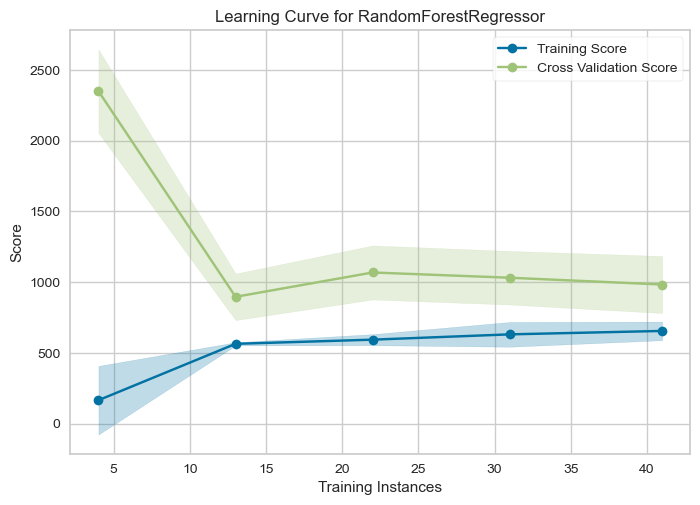

<Axes: title={'center': 'Learning Curve for RandomForestRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [160]:
from yellowbrick.model_selection import LearningCurve
from sklearn.metrics import mean_squared_error, make_scorer

# Load a regression dataset
X= exp3.get_config('X_train_transformed')
y= exp3.get_config('y_train_transformed')

# Instantiate the regression model and visualizer

visualizer = LearningCurve(hyper_exp3, scoring=make_scorer(mean_squared_error,squared=False))

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()

In [163]:
pred_model = exp3.predict_model(hyper_exp3 )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,460.0215,345519.7707,587.8093,0.8583,0.3048,0.2234


In [164]:
pred_model_test = exp3.predict_model(hyper_exp3, data=df_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,770.4943,1411078.8147,1187.8884,0.5739,0.4371,0.2551


Finalize

In [166]:
final_mod = exp3.finalize_model(hyper_exp3)

### **Interpretation**

The best model that are given from experiment is random forest in which is an ensemble learning method used for regression tasks. It combines multiple decision trees trained on random subsets of the data and features to reduce overfitting. The final prediction is an average of all individual tree predictions. RF also provides feature importance scores, indicating which features influence predictions the most. While highly accurate, RF models offer limited interpretability compared to simpler models. Techniques like partial dependence plots and permutation importance can help gain insights into feature effects. Overall, RF excels in handling complex datasets and delivering robust predictions.

***

### **Recommendation**

1. Addresing Target Outlier

In this data, there are many target outlier that can not be explain by feature. For example: Toyota Fortuner 2023 with Price of 1000 SAU. We assume that the price happened because the condition that can not be xplained in the df. Suhc as: the car that sell because of crash, the cara that sell because its been flooden, the car 

If we want to explain this outlier in the model and not just used the handling method for model, we need to gather more information. For example:

- Machine Condition Rating (1-10)
- Car Body Condition Rating (1-10)
- Accident History (Yes/No)
- Flood Damage History (Yes/No)
- Previous Owners (Number)
- Service History (Complete/Incomplete)
- Modifications (Yes/No, with details if possible)

2. Create A/B testing for model

To ensure the effectiveness of incorporating these new features, it is recommended to set up A/B testing for the model. This involves:

- Control Group: Train a model using the existing features.
- Test Group: Train another model that includes the additional features.

Compare the performance of these models using relevant metrics (e.g., RMSE, MAE) to evaluate whether the inclusion of new features significantly improves the model's predictive accuracy.

3. Recommendation for Further Development

For the further development of the machine learning regression model for predicting car prices, consider the following steps:

- Data Collection and Integration: Systematically gather the additional features identified above and integrate them into your existing dataset. Ensure the data is cleaned and standardized.

- Regular Updates and Monitoring: Continuously update the dataset with new information and monitor the model’s performance. Set up a feedback loop to regularly incorporate new data and retrain the model.

- Expert Consultation: Engage with domain experts to identify other potential features that could impact car prices and incorporate their insights into the model.

- User Feedback: Implement mechanisms to gather user feedback on the model’s predictions to further refine and improve its accuracy over time.

By following these steps, you can enhance the model’s ability to accurately predict car prices, taking into account previously unexplained outliers and improving overall performance.








****

#### **Save Model**

In [176]:
exp3.save_model(final_mod,'finalmodel',verbose=False)

(Pipeline(memory=Memory(location=None),
          steps=[('custom_step',
                  TransformerWrapper(transformer=ColumnTransformer(transformers=[('cat1_type',
                                                                                  Pipeline(steps=[('binary',
                                                                                                   BinaryEncoder()),
                                                                                                  ('select',
                                                                                                   SelectKBest(k=7,
                                                                                                               score_func=<function mutual_info_regression at 0x00000248B3379C60>))]),
                                                                                  ['Make']),
                                                                                 ('cat2',
               

In [ ]:
Load model
filename = 'Model_Car.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [139]:
df_seen.to_csv('dfseen.csv', index=False)
df_unseen.to_csv('dfunseen.csv', index=False)